### Onetime Setup

In [ ]:
%%capture
!pip install mne
!pip install pywavelets

## Setup

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import mne

CATEGORIES = ('Healthy', 'Epileptic')


In [40]:
%%capture
PATH_TO_DATA = "Data/"
categories = ('Healthy', 'Epileptic')

dataset = {categories[0]: [], categories[1]: []}

for category in categories:
  for file_name in glob.glob(f'{PATH_TO_DATA}/{category}/*.fif'):
    file_data = mne.io.read_raw_fif(file_name, preload=True)
    dataset[category].append(file_data)


KeyboardInterrupt: 

In [41]:
import pickle

# with open('Data/data_eeg.pkl', 'wb') as file:
#     pickle.dump(dataset, file)

with open('Data/data_eeg.pkl', 'rb') as file:
    dataset = pickle.load(file)

# Process

In [42]:
raw = dataset['Healthy'][0]
raw1 = dataset['Epileptic'][0]

In [43]:
sfreq = dataset['Healthy'][0].info['sfreq']
sfreq

125.0

In [44]:
dataset['Healthy'][0].info['highpass']

3.0

In [45]:
dataset['Healthy'][0].info['lowpass']

30.0

In [46]:
dataset['Healthy'][0]

Measurement date,"November 21, 2022 10:46:26 GMT"
Experimenter,Unknown
Participant,HRV010
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,3.00 Hz
Lowpass,30.00 Hz


In [47]:
!git clone https://github.com/chendaichao/Hilbert-Huang-transform.git
!mv /content/Hilbert-Huang-transform/torchHHT .

fatal: destination path 'Hilbert-Huang-transform' already exists and is not an empty directory.
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchHHT import hht, visualization
from scipy.signal import chirp
import IPython
from scipy.stats import norm
import glob
import mne

In [49]:
def get_summed_data(raw_data): return np.sum(raw_data.get_data(), axis = 0)

In [ ]:
def get_hht_feature(arr):
  arr.to('cuda')
  _, imfs_env, imfs_freq = hht.hilbert_huang(arr, SAMPLING_FREQ, num_imf=3)
  spectrum, _, _ = hht.hilbert_spectrum(imfs_env, imfs_freq, SAMPLING_FREQ, freq_lim = (2, 31), time_scale=1, freq_res = 1)
  return np.array([torch.sum(spectrum[:, :10]), torch.sum(spectrum[:, 10:20]), torch.sum(spectrum[:, 20:])])
  # return spectrum


In [51]:
SAMPLING_FREQ = 125
get_hht_feature(get_summed_data(raw1)[:512])

array([9.5396254e-06, 6.2654785e-06, 1.2463119e-06], dtype=float32)

In [52]:
SAMPLING_FREQ = 125
BOOL_LABELS = {CATEGORIES[0]:0, CATEGORIES[1]:1}
def generate_dataset(raw_dataset, window=512, stride = 448):
  X, y = [], []
  for category in CATEGORIES:
    label = BOOL_LABELS[category]
    for patient_data in raw_dataset[category]:
      if patient_data.info['sfreq'] == SAMPLING_FREQ:
        summed_data = get_summed_data(patient_data)
        for i in range(0, summed_data.shape[0]-64, stride):
          X.append(get_hht_feature(summed_data[i:i+window]))
          y.append(label)

  return np.array(X), np.array(y)

In [54]:
X, y = generate_dataset(dataset)

In [93]:
X_new = X.reshape(3, 6495)

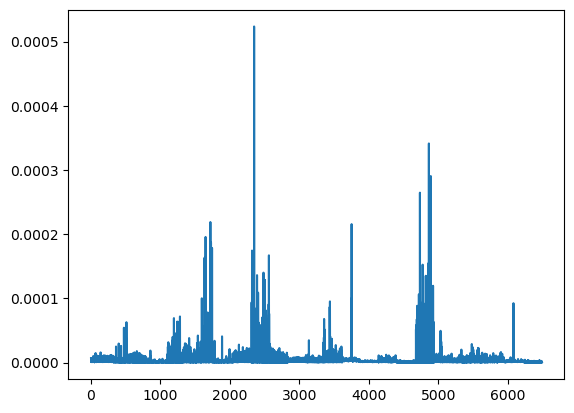

In [98]:
plt.plot(X_new[2])
kernel0 = gaussian_kde(X[:upto].T)
kernel1 = gaussian_kde(X[upto:].T)
y0 = kernel0(X.T)
y1 = kernel1(X.T)

In [127]:
for i in y0:
    print(f"{i0.2f}",)

SyntaxError: invalid decimal literal (1842619516.py, line 2)

In [70]:
upto = 6495 - sum(y)
upto

2535

### Guassian Kernel Density estimation

In [71]:
from scipy.stats import gaussian_kde
kernel0 = gaussian_kde(X[:upto].T)
kernel1 = gaussian_kde(X[upto:].T)

In [ ]:
y0 = kernel0(X.T)
y1 = kernel1(X.T)

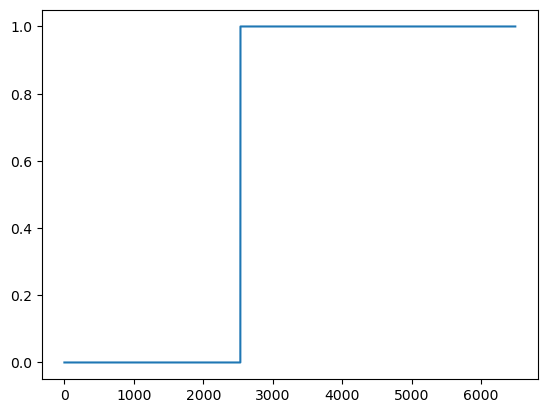

In [86]:
plt.plot(y)

In [80]:
r = y1 / y0
np.sum(r > 1)

C:\Users\abhis\AppData\Local\Temp\ipykernel_12116\47330515.py:1: RuntimeWarning: divide by zero encountered in divide
  r = y1 / y0
C:\Users\abhis\AppData\Local\Temp\ipykernel_12116\47330515.py:1: RuntimeWarning: overflow encountered in divide
  r = y1 / y0


1887

In [81]:
r.shape

(6495,)

In [82]:
dd = X[-32:].T
# dd = X[:16].T
kernel1(dd) / kernel0(dd)

array([0.21061049, 0.27005314, 0.22158938, 0.24846037, 0.27085089,
       0.34956777, 0.30012372, 0.26387781, 0.35779402, 0.25639364,
       0.23432794, 0.22963387, 0.20456571, 0.21526314, 0.25690225,
       0.23122429, 0.26411492, 0.22933463, 0.25519514, 0.30771354,
       0.30329453, 0.20629122, 0.24989702, 0.25371446, 0.29833747,
       0.20266755, 0.23915715, 0.30781604, 0.47838315, 0.29894108,
       0.25822925, 0.71560553])

In [114]:
def get_roc_data(y, y1, y0):
  r = y1 / y0
  # import ipdb 
  # ipdb.set_trace()
  total = len(y)
  # y = np.array(y, dtype=np.bool)
  tpr, fpr = [], []
  for thresh in np.arange(0.01, 10, 0.1):
    c = r > thresh
    c = np.array(c, dtype=np.int32)
    diff = 5*c - 2*y
    tp = np.sum(diff == 3) / total
    fp = np.sum(diff == 5) / total
    if fp == 0 : 
        fp = 1e-3
    fpr.append(fp)
    tpr.append(tp)
  return np.array(fpr) , np.array(tpr)

C:\Users\abhis\AppData\Local\Temp\ipykernel_12116\2335707123.py:2: RuntimeWarning: divide by zero encountered in divide
  r = y1 / y0
C:\Users\abhis\AppData\Local\Temp\ipykernel_12116\2335707123.py:2: RuntimeWarning: overflow encountered in divide
  r = y1 / y0


(100,) (100,)


ValueError: x is neither increasing nor decreasing : [3.85373364e-01 3.72902232e-01 2.79291763e-01 1.76597383e-01
 1.39491917e-01 1.14395689e-01 9.17628945e-02 7.71362587e-02
 6.65127021e-02 5.92763664e-02 4.95765974e-02 4.06466513e-02
 3.43341032e-02 2.86374134e-02 2.26327945e-02 1.84757506e-02
 1.64742109e-02 1.46266359e-02 1.27790608e-02 1.17013087e-02
 1.04695920e-02 9.39183988e-03 8.46805235e-03 7.85219400e-03
 6.31254811e-03 5.69668976e-03 4.92686682e-03 4.31100847e-03
 3.69515012e-03 2.61739800e-03 2.46343341e-03 1.84757506e-03
 1.38568129e-03 9.23787529e-04 7.69822941e-04 7.69822941e-04
 6.15858353e-04 6.15858353e-04 6.15858353e-04 3.07929176e-04
 3.07929176e-04 1.53964588e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03].

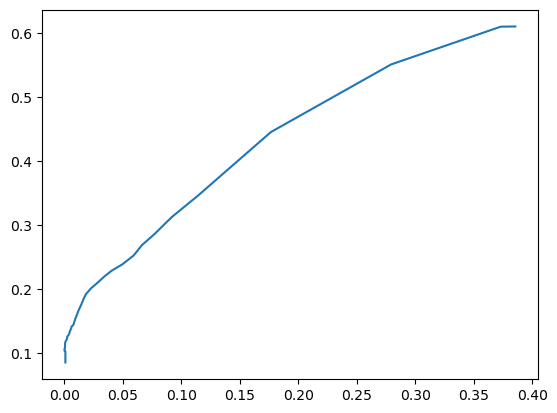

In [115]:
from sklearn.metrics import roc_curve, auc

# fpr, tpr, thresholds = roc_curve(y, y1 / y0)
fpr, tpr = get_roc_data(y, y1, y0)
plt.plot(fpr, tpr)
print(fpr.shape,  tpr.shape)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
sum(fpr)

In [88]:
sum(tpr)

14.018321785989224

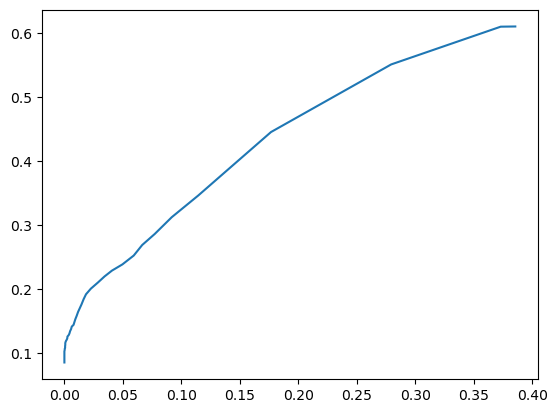

In [108]:
 plt.plot(fpr , tpr)

In [105]:
tpr

array([0.60969977, 0.60939184, 0.5504234 , 0.4448037 , 0.38568129,
       0.3456505 , 0.31177829, 0.28545035, 0.26836028, 0.25188607,
       0.23802925, 0.22832948, 0.21924557, 0.20969977, 0.20015396,
       0.19137798, 0.18383372, 0.17551963, 0.16812933, 0.16381832,
       0.15750577, 0.15257891, 0.14734411, 0.14364896, 0.1408776 ,
       0.13687452, 0.13394919, 0.13010008, 0.12763664, 0.12532717,
       0.12240185, 0.11993841, 0.11855273, 0.11639723, 0.11485758,
       0.11224018, 0.11054657, 0.10854503, 0.10762125, 0.10623557,
       0.10531178, 0.10331024, 0.10223249, 0.10161663, 0.09961509,
       0.09946112, 0.09899923, 0.09822941, 0.09761355, 0.09699769,
       0.09638183, 0.09576597, 0.09499615, 0.09468822, 0.09453426,
       0.0939184 , 0.09345651, 0.09314858, 0.09284065, 0.09222479,
       0.09191686, 0.09176289, 0.091301  , 0.09099307, 0.09037721,
       0.09006928, 0.08991532, 0.08945343, 0.08899153, 0.08883757,
       0.08837567, 0.08822171, 0.08806774, 0.08791378, 0.08775

In [109]:
fpr

array([3.85373364e-01, 3.72902232e-01, 2.79291763e-01, 1.76597383e-01,
       1.39491917e-01, 1.14395689e-01, 9.17628945e-02, 7.71362587e-02,
       6.65127021e-02, 5.92763664e-02, 4.95765974e-02, 4.06466513e-02,
       3.43341032e-02, 2.86374134e-02, 2.26327945e-02, 1.84757506e-02,
       1.64742109e-02, 1.46266359e-02, 1.27790608e-02, 1.17013087e-02,
       1.04695920e-02, 9.39183988e-03, 8.46805235e-03, 7.85219400e-03,
       6.31254811e-03, 5.69668976e-03, 4.92686682e-03, 4.31100847e-03,
       3.69515012e-03, 2.61739800e-03, 2.46343341e-03, 1.84757506e-03,
       1.38568129e-03, 9.23787529e-04, 7.69822941e-04, 7.69822941e-04,
       6.15858353e-04, 6.15858353e-04, 6.15858353e-04, 3.07929176e-04,
       3.07929176e-04, 1.53964588e-04, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 1.00000000e-05,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05, 1.00000000e-05,
      